## Optimizing for efficient Molecular Cross-Validation

Molecular cross-validation (MCV) lets us find the optimal settings for a scRNAseq denoiser, but checking many different parameter settings requires running the denoiser many times. Depending on the method and the size of the parameter grid, this can take a significant amount of time.

Because each run is independent, the grid-search process can be trivially parallelized*. However, this requires computational resources that scale with the size of the parameter grid to be searched. Another option is to take advantage of redundant steps in the denoiser method that can be shared across runs. In this notebook we demonstrate the impact of this strategy for two methods: PCA and network diffusion.

This notebook was run on a very large machine with 64 CPUs and 2TB of RAM. Some methods from `scikit-learn` are internally multi-threaded and so performance will differ on other machines.

**Note**: parallelization can vastly speed up the search, but in our experience different splits of the raw data will generate MCV curves that differ by a constant factor. Therefore, it is important to keep the split consistent when running a grid search over different parameter settings, so that the results can be compared. Alternatively one can use a large number of replicates for each setting, at the cost of additional computation time.

In [1]:
import csv
import gzip

from collections import defaultdict
from typing import Sequence, Union

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd
from sklearn.utils.validation import check_random_state

import molecular_cross_validation.util as ut

from molecular_cross_validation.mcv_sweep import GridSearchMCV, poisson_nll_loss

seed = sum(map(ord, f"grid_search_vignette"))

/home/james/anaconda3/envs/mcv/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


### The Data

We'll use the data from Paul, Arkin, & Giladi _et al._. Download from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72857) and place in `data/myeloid`. After processing, the dataset consists of 2417 cells and 10783 genes.

In [2]:
# read in metadata file to get sample annotations
with gzip.open("../data/myeloid/GSE72857_experimental_design.txt.gz", "rt") as f:
    rdr = csv.reader(f, delimiter='\t')
    row = next(rdr)
    for row in rdr:
        if row[0] == "Well_ID" and row[1] == "Seq_batch_ID":
            break

    rows = list(csv.DictReader(f, fieldnames=row, delimiter="\t"))
    
# read in text file as AnnData object
with gzip.open("../data/myeloid/GSE72857_umitab.txt.gz", "rt") as f:
    myeloid_ad = sc.read_text(f, delimiter="\t", first_column_names=True).T

# filter to myeloid samples
myeloid_ids = [
    r["Well_ID"] for r in rows if r["Batch_desc"] == "Unsorted myeloid"
]
myeloid_ad = myeloid_ad[myeloid_ids, :]

# filter to ≥1000 UMIs per cell and ≥10 cells per gene
sc.pp.filter_cells(myeloid_ad, min_counts=1000)
sc.pp.filter_genes(myeloid_ad, min_cells=10)

umis = np.asarray(myeloid_ad.X.astype(int))

Trying to set attribute `.obs` of view, copying.


## Defining a denoiser

A denoiser is just a function that takes an `numpy.ndarray` of UMIs and returns a denoised version. This function can take any form as long as the returned array is of the same shape and scale as the original data. Parameters for the denoiser are passed in as keyword arguments and will be calibrated by grid search using the MCV loss.

### Principal Component Analysis

PCA acts as a simple denoiser by projecting the data into a linearly independent coordinate system, discarding the less significant dimensions, and then transforming the data back into the original space. _[need to reword this]_

In this example we perform PCA in two steps:
 1. Use singular value decomposition to go from the input matrix $X$ to $U, \Sigma, V^T$, where $X = U \Sigma V^T$ where $\Sigma$ is a $n \times p$ diagonal matrix of the singular values of $X$
 2. Calculate a denoised $X_k$ by using only the first $k$ components: $X_k = U_k {\Sigma}_k V^T_k$ where the subscript $k$ indicates we are using the first $k$ columns of the matrix.
 
In this method we use a square-root transformation on the raw counts that our signal is not dominated by changes in highly expressed genes.

In [3]:
# naive PCA: calculate the requested number of components and 
def naive_pca(
    umis: np.ndarray, 
    n_components: int,
    random_state: Union[int, np.random.RandomState] = None,
):
    rng = check_random_state(random_state)
    
    # here we use scikit-learn's implementation of SVD,
    # which will return only the desired number of components
    U, S, V = randomized_svd(umis, n_components, random_state=rng)
    
    return U.dot(np.diag(S)).dot(V)

### `GridSearchMCV` with PCA

Now that we have our PCA denoiser, we can use the `GridSearchMCV` class from our [repository](www.github.com/czbiohub.molecular-cross-validation). This class searches over a parameter grid for a given denoiser. The interface is inspired by scikit-learn's [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), but it is slightly different due to the nature of the MCV process.

Additional options at initialization are:
  
 - `data_split` : Proportion of UMIs to use for denoising (default 0.9).
 - `sample_ratio` : Estimated ratio of counts in the sample compared to the original cells.
 - `n_splits` : Number of times to split UMIs for a given parameterization.
 - `loss` : either `mse` or `poisson`.
 - `transformation` : Transformation to apply to count matrix before denoising. Either `None`, `'sqrt'`, or an arbitrary function. If a function is used, `data_split` must be 0.5.
 -  `random_state` : If int, random_state is the seed used by the random number generator. If RandomState instance, random_state is the random number generator. If None, the random number generator is the RandomState instance used by `np.random`.

The `fit` method will split the original data into two parts, $X^{\prime}$ and $X^{\prime\prime}$, according to the parameter `data_split`. For each combination of parameters, the denoiser will be applied to $X^{\prime}$ and evaluated on $X^{\prime\prime}$, and the resulting MCV loss will be recorded. After `fit` has been called, the `best_params_` attribute will contain the parameters that yielded the best MCV loss, and the loss itself will be in `best_loss_`. The `cv_results_` attribute will contain the results for all of the tested parameters.

In concordance with the scikit-learn interface, `transform` applies the model selected by MCV to the input data, and `fit_transform` sequentially fits the model and transforms the data.

In [4]:
%%time

naive_pca_sweep = GridSearchMCV(
    naive_pca,
    param_grid={"n_components": np.arange(1, 51)},
    data_split=0.9,
    n_splits=1,
    loss="mse",
    transformation="sqrt",
    random_state=np.random.RandomState(seed),
).fit(umis)

naive_pca_mcv = pd.DataFrame(naive_pca_sweep.cv_results_)

CPU times: user 42min 56s, sys: 1min 23s, total: 44min 20s
Wall time: 1min 40s


### Optimizing PCA

The interface for `GridSearchMCV` is simple because it calls the denoising function separately for each parameter setting. However, this comes at the cost of repeating many similar computations. In the case of PCA, we can write an optimized version by computing it once for the maximum number of components, precompute $\mathbf{U} \cdot \Sigma$, and then use submatrices of $\mathbf{U}$, $\Sigma$, and $\mathbf{V^T}$ as needed.

In [5]:
def optimized_pca_sweep(
    umis: np.ndarray,
    n_splits: int,
    data_split: float,
    n_components: Sequence[int],
    random_state: Union[int, np.random.RandomState] = None
):
    rng = check_random_state(random_state)
    
    max_components = max(n_components)

    mcv_loss = np.empty((n_splits, n_components.shape[0]), dtype=float)

    # run n_trials for self-supervised sweep
    for i in range(n_splits):
        umis_X, umis_Y = ut.split_molecules(umis, data_split, 0.0, random_state=rng)

        umis_X = np.sqrt(umis_X)
        umis_Y = np.sqrt(umis_Y)

        U, S, V = randomized_svd(umis_X, n_components=max_components, random_state=rng)
        US = U.dot(np.diag(S))

        for j, k in enumerate(n_components):
            pca_X = US[:, :k].dot(V[:k, :])

            mcv_loss[i, j] = mean_squared_error(umis_Y, ut.convert_expectations(pca_X, data_split))

    return pd.DataFrame(
        {"n_components": n_components, "mcv_loss": mcv_loss.mean(0)}
    )

In [6]:
%%time

optimized_pca_mcv = optimized_pca_sweep(
    umis,
    n_splits=1,
    n_components=np.arange(1, 51),
    data_split=0.9,
    random_state=np.random.RandomState(seed),
)

CPU times: user 15min 9s, sys: 41.1 s, total: 15min 50s
Wall time: 1min 15s


Looking at the timing results, we see that our optimized version saved ~20 minutes of CPU time on this machine. Some operations are repeated per-trial and so they still take time in proportion to the number of parameters tested, but we have saved a considerable amount of time. The amount of wall time saved depends on how many cores `scikit-learn` uses for computing the SVD.

The resulting MCV loss curves appear nearly identical. The optimized curve is slightly smoother because the smaller decompositions are exact subsets of the full matrix, whereas the naïve version will have some numerical errors.

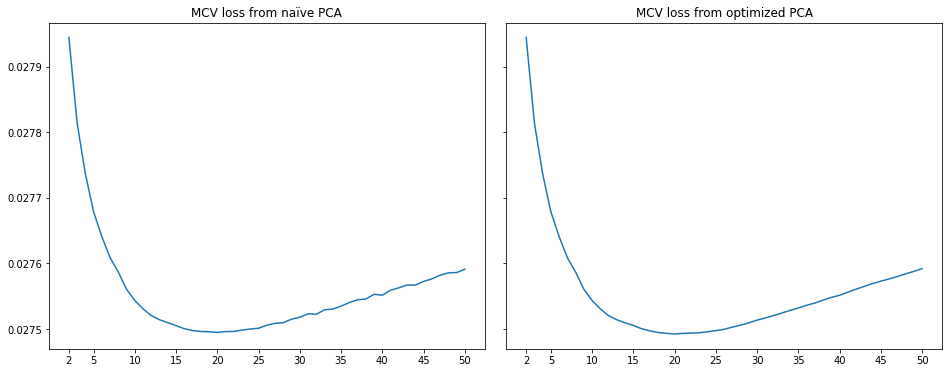

In [7]:
fig,ax = plt.subplots(
    1, 2, figsize=(16, 6), sharex=True, sharey=True, gridspec_kw={'wspace': 0.05}
)

# the first loss is relatively high, we will skip plotting it
k = 1

ax[0].plot(
    naive_pca_mcv['n_components'][k:],
    naive_pca_mcv['mcv_loss'][k:]
)
ax[0].set_title("MCV loss from naïve PCA")
ax[1].plot(
    optimized_pca_mcv['n_components'][k:], 
    optimized_pca_mcv['mcv_loss'][k:],
)
ax[1].set_title("MCV loss from optimized PCA")

ax[0].set_xticks([2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

plt.show()

## Optimizing a more complex denoiser: Diffusion

Now we will demonstrate the same procedure for a slightly more complex method. This diffusion denoiser takes a similar approach to the MAGIC algorithm from van Dijk _et al._.

 1. Normalize the counts per-cell.
 2. Compute SVD as before on square-root UMI counts. Project the normalized data into PCA space.
 3. Compute a $k$-nearest-neighbors (kNN) graph on the projection and use that to create a diffusion operator, which is a transition probability matrix based on the graph.
 4. Diffuse the normalized counts over this graph for a given number of time steps.
 5. Re-scale back up using the cell counts.

This method has four different parameters that can be optimized:
 - `n_components`: number of components to use in step 2.
 - `n_neighbors`: number of neighbors to use in step 3.
 - `tr_prob`: A weighting factor to adjust the transition probability matrix.
 - `time_steps`: How many times to diffuse counts in step 4.
 
Here we will demonstrate how to use `GridSearchMCV` to sweep over `n_components` and `time_steps`, and then show an optimized version of the same process. We will keep `n_neighbors` and `tr_prob` constant for simplicity.

In [8]:
# the basic diffusion algorithm, for a given parameter setting
def naive_diffusion(
    umis: np.ndarray,
    time_steps: int,
    n_components: int,
    n_neighbors: int = 15,
    tr_prob: float = 0.5,
    random_state: np.random.RandomState = None,
):
    rng = check_random_state(random_state)

    # calculate row sums and normalize counts
    row_sums = umis.sum(1, keepdims=True)
    norm_umis = sklearn.preprocessing.normalize(umis.astype(np.float), norm='l1')

    # calculate PCA as before
    U, S, V = randomized_svd(np.sqrt(norm_umis), n_components, random_state=rng)
    US = U.dot(np.diag(S))

    # calculate a kNN in PCA space
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute').fit(US)

    knn_arr = nbrs.kneighbors_graph(US, mode="connectivity")
    knn_arr = sklearn.preprocessing.normalize(knn_arr + knn_arr.T, norm="l1")

    diff_op = np.asarray(tr_prob * knn_arr + (1 - tr_prob) * np.eye(knn_arr.shape[0]))

    diff_umis = norm_umis.copy()
    for t in range(time_steps):
        diff_umis = diff_op.dot(diff_umis)

    return diff_umis * row_sums

### `GridSearchMCV` with diffusion

Again, we use the `GridSearchMCV` class to search over a grid of parameters. In this case we vary two different parameters. Because we included default values for the other parameters in our function, we do not need to include them here.

In [9]:
%%time

naive_diffusion_sweep = GridSearchMCV(
    naive_diffusion,
    param_grid={
        "time_steps": np.arange(3, 16),
        "n_components": [10, 20, 30, 40]
    },
    data_split=0.9,
    n_splits=1,
    loss="poisson",
    transformation=None,
    random_state=np.random.RandomState(seed),
).fit(umis)

naive_diffusion_mcv = pd.DataFrame(naive_diffusion_sweep.cv_results_)

CPU times: user 7h 44min 45s, sys: 8min 30s, total: 7h 53min 16s
Wall time: 8min 53s


### Optimizing the diffusion method

There are three different opportunities to optimize this method. Because the first step of the algorithm is PCA, we can use the same optimization we performed above and compute a single decomposition with the maximum number of components. It is also possible to do a similar optimization when computing multiple kNN graphs, because a graph with a higher $k$ contains all of the edges from a graph with a lower $k$. Most consequentially, for a given transition matrix, diffusion to time step $t + 1$ is simply the dot product of the diffusion operator and the result from time step $t$. We implement these optimizations in the code below.

In [10]:
def optimized_diffusion_sweep(
    umis: np.ndarray,
    n_splits: int,
    data_split: float,
    time_steps: Sequence[int],
    n_components: Sequence[int],
    n_neighbors: Sequence[int],
    tr_prob: Sequence[float],
    random_state: Union[int, np.random.RandomState] = None,
):
    rng = check_random_state(random_state)
    
    # function to scale the predicted value for a poisson loss
    convert = lambda x: x * (1 - data_split) / data_split

    max_time = max(time_steps)
    max_components = max(n_components)
    max_neighbors = max(n_neighbors)

    losses = defaultdict(list)

    for i in range(n_splits):
        umis_X, umis_Y = ut.split_molecules(umis, data_split, 0.0, random_state=rng)

        row_sums = umis_X.sum(1, keepdims=True)
        norm_umis = sklearn.preprocessing.normalize(umis_X.astype(np.float), norm='l1')

        U, S, V = randomized_svd(np.sqrt(norm_umis), max_components, random_state=rng)
        US = U.dot(np.diag(S))

        for n_c in n_components:
            nbrs = NearestNeighbors(n_neighbors=max_neighbors, algorithm='brute').fit(US[:, :n_c])

            for n_n in n_neighbors:
                knn_arr = nbrs.kneighbors_graph(US[:, :n_c], n_neighbors=n_n, mode="connectivity")
                knn_arr = sklearn.preprocessing.normalize(knn_arr + knn_arr.T, norm="l1")

                for tr_p in tr_prob:
                    diff_op = np.asarray(tr_p * knn_arr + (1 - tr_p) * np.eye(knn_arr.shape[0]))
                    diff_umis = norm_umis.copy()

                    # NB: here we go to max_time + 1 because are computing the loss
                    # before we perform the diffusion step
                    for t in range(max_time + 1):
                        if t in time_steps:
                            losses[n_c, n_n, tr_p, t].append(
                                poisson_nll_loss(convert(diff_umis * row_sums), umis_Y)
                            )
                        diff_umis = diff_op.dot(diff_umis)

    return pd.DataFrame(
        [
            {
                "n_components": n_c,
                "n_neighbors": n_n,
                "tr_prob": tr_p,
                "time_steps": t,
                "mcv_loss": np.mean(losses[n_c, n_n, tr_p, t])
            } 
             for (n_c, n_n, tr_p, t) in losses
        ]
    )

In [11]:
%%time

optimized_diffusion_mcv = optimized_diffusion_sweep(
    umis,
    n_splits = 1,
    data_split = 0.9,
    time_steps = np.arange(3, 16),
    n_components = np.arange(10, 41, 10),
    n_neighbors = [15],
    tr_prob = [0.5],
    random_state=np.random.RandomState(seed),
)

CPU times: user 1h 12min 16s, sys: 1min 33s, total: 1h 13min 50s
Wall time: 1min 55s


Here we see a much larger speed up in CPU time, from 8 hours to 1.5. This is because we have saved many repetitions of some of the more time-consuming steps, such as kNN graph construction. The wall time goes from 9 minutes to 2 minutes on this machine.

After running the MCV parameter search, we can plot the results and identify the optimal parameter settings, shown below. Note again that the results of the optimized search match with the results from `GridSearchMCV`.

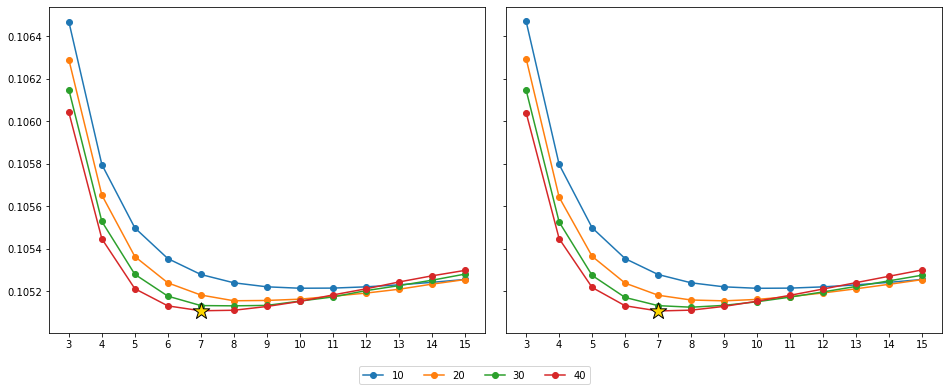

In [12]:
fig,ax = plt.subplots(
    1, 2, figsize=(16, 6), sharex=True, sharey=True, gridspec_kw={'wspace': 0.05}
)

for i,mcv_df in enumerate((naive_diffusion_mcv, optimized_diffusion_mcv)):
    mcv_arr = mcv_df["mcv_loss"].values.reshape((13, 4), order="F")
    line_obj = ax[i].plot(np.arange(3, 16), mcv_arr, marker="o")

    # mark the optimal value
    ax[i].scatter(
        [3 + mcv_arr.min(1).argmin()], [mcv_arr.min(1).min()], 
        marker="*", linewidths=1, edgecolor="k", s=300, c="gold", zorder=3
    )
    ax[i].set_xticks(np.arange(3, 16))

plt.figlegend(iter(line_obj), ('10', '20', '30', '40'), loc=8, ncol=4)
plt.show()

We can also plot the expression of _Apoe_ and _Gata1_ as in Figure 2b. Reassuringly we observe the same qualitative relationship between the genes using both methods. For the sake of comparison we square-root transform the denoised output.

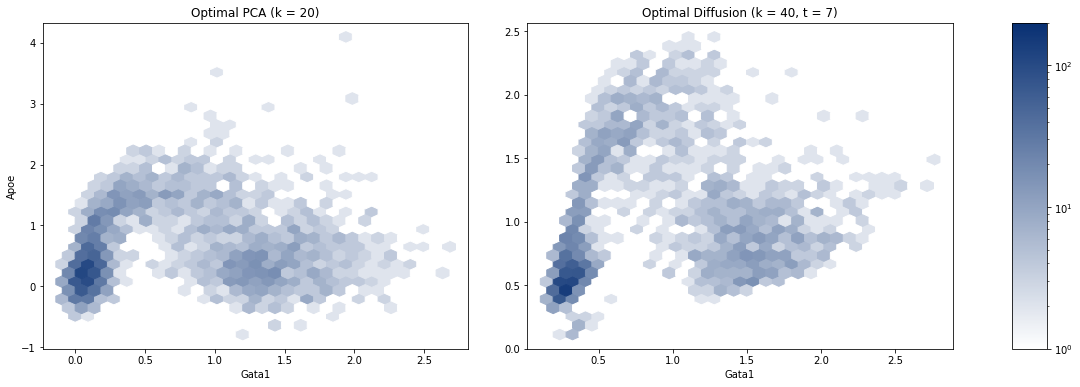

In [13]:
# the optimal PCA transformation for sqrt-transformed data
optimal_pca = naive_pca(np.sqrt(umis), n_components=20)

# we will sqrt the output for comparison
optimal_diffusion = np.sqrt(naive_diffusion(umis, time_steps=7, n_components=40))


fig,ax = plt.subplots(
    1, 3, figsize=(18,6), gridspec_kw={"width_ratios": [12, 12, 1]}
)

# version of 'Blues' colormap that is pure white at the bottom
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "BluesW",
    [(1.0, 1.0, 1.0), (0.0314, 0.188, 0.450)]
)

titles = ["Optimal PCA (k = 20)", "Optimal Diffusion (k = 40, t = 7)"]

for i,denoised_umis in enumerate((optimal_pca, optimal_diffusion)):
    m = ax[i].hexbin(
        denoised_umis[:, myeloid_ad.var.index.get_loc("Gata1")],
        denoised_umis[:, myeloid_ad.var.index.get_loc("Apoe")],
        gridsize=30,
        bins='log',
        cmap=cmap,
        vmin=1,
        vmax=200,
    )

    ax[i].set_xlabel("Gata1")
    ax[i].set_title(titles[i])

ax[0].set_ylabel("Apoe")
    
plt.colorbar(m, cax=ax[2])
plt.savefig("../figures/Figure_S-TK2_raw.svg")
plt.show()